# Data Science Analysis [EP4130]
# Project: Monte Carlo methods for Bayesian Inference

## Team Members
 * **Pradeep Mundlik, ai21btech11022@iith.ac.in**
 * **Sheyas Wankhede, ai21btech11022@iith.ac.in**

**This notebook contains the code in `python` for the project where monte carlo methods are used for sampling in bayesian inference.**

## Link to Github Repository: [Github](https://github.com/shreyaswankhede12/DSA-project)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# !pip3 freeze > requirements.txt
# !pip3 install -r requirements.txt


In [133]:
n = 100
y = 30

## MCMC - Univariate Case

$$ y \mid \theta \sim bin(n,\theta) $$
$$ n = 100, y = 30 $$
Prior: $$ f(\theta) = e - e^\theta $$
Likelihood: $$ L(\theta \mid y) = \binom{n}{y} \theta^y (1-\theta)^{n-y} \propto \theta^y (1-\theta)^{n-y}$$
Posterior: $$ f(\theta \mid y) \propto f(\theta) \times L(\theta \mid y) $$
$$ f(\theta \mid y) \propto (e - e^\theta) \theta^y (1-\theta)^{n-y} $$

Proposal Distribution:

$$ \theta' \mid \theta \sim beta(\alpha, \beta) $$ 
$$ \alpha = \theta, \beta = 1-\theta \implies E[\theta' \mid \theta] = \frac{\alpha}{\alpha + \beta} = \theta $$


In [134]:
def likelihood(theta, n, y):
    return stats.binom.pmf(y, n, theta)

def prior(theta):
    return np.exp(1) - np.exp(theta)

def metropolis_hasting(n, y, theta_init, n_iter=1000):
    
    theta = [theta_init]
    theta_current = theta_init
    
    for i in range(n_iter-1):
        
        # theta_prop = stats.beta.rvs(theta_current, 1-theta_current)
        theta_prop = np.random.normal(theta_current, 0.01)
        
        if theta_prop < 0 or theta_prop > 1:
            theta.append(theta_current)
            continue
        
        p_prop = likelihood(theta_prop, n, y) * prior(theta_prop)
        p_current = likelihood(theta_current, n, y) * prior(theta_current)
        
        alpha = p_prop / p_current # (stats.beta.pdf(theta_current, theta_prop, 1-theta_prop) / stats.beta.pdf(theta_prop, theta_current, 1-theta_current))
                
        if np.random.uniform() < alpha:
            theta_current = theta_prop
        
        theta.append(theta_current)
    
    return theta

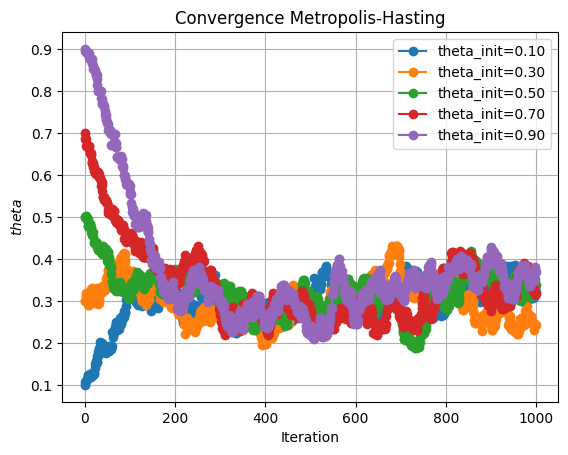

In [135]:
theta_init = np.arange(0.1, 1, 0.2)

for i in range(theta_init.shape[0]):
    theta = metropolis_hasting(n, y, theta_init[i])
    theta = np.array(theta)
    plt.plot(theta, '-o', label=f'theta_init={theta_init[i]:.2f}')
    plt.scatter(np.arange(theta.shape[0]), theta, s=1)

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('$theta$')
plt.title('Convergence Metropolis-Hasting')
plt.grid()
plt.show()

## MCMC - Bivariate Case
$$ y = [y_1, y_2],  \theta = [\theta_1, \theta_2] $$
$$ y_1 \mid \theta \sim bin(n_1,\theta_1), y_2 \mid \theta \sim bin(n_2,\theta_2) $$
Prior: $$ f(\theta) = f(\theta_1) \times f(\theta_2) $$
Likelihood: $$ L(\theta_1, \theta_2 \mid y_1, y_2) = \binom{n_1}{y_1} \binom{n_2}{y_2} \theta_1^{y_1} (1-\theta_1)^{n_1-y_1} \theta_2^{y_2} (1-\theta_2)^{n_2-y_2}$$
Posterior: $$ f(\theta \mid y) \propto f(\theta) \times L(\theta \mid y) $$

Proposal Distribution:

$$ \theta' \mid \theta \sim \text{Multivariate Normal, mean = $\theta$} $$


In [136]:
# bivariate binoomial
n1 = 100
n2 = 200
y1 = 30
y2 = 25

def prior(theta):
    return (np.exp(1) - np.exp(theta[0])) * (np.exp(1) - np.exp(theta[1]))

def likelihood(theta, n1, n2, y1, y2):
    return stats.binom.pmf(y1, n1, theta[0]) * stats.binom.pmf(y2, n2, theta[1])

def metropolis_hasting_bivariate(n1, n2, y1, y2, theta_init, n_iter=1000):
    theta = [theta_init]
    theta_current = theta_init
    
    for i in range(n_iter):
        
        theta_prop = np.random.multivariate_normal(np.zeros(2), np.eye(2) * 0.01) + theta_current
        
        if theta_prop.any() < 0 or theta_prop.any() > 1:
            continue
        
        p_prop = likelihood(theta_prop, n1, n2, y1, y2) * prior(theta_prop)
        p_current = likelihood(theta_current, n1, n2, y1, y2) * prior(theta_current)
        
        alpha = p_prop / p_current
        
        if np.random.uniform() < alpha:
            theta_current = theta_prop
        
        theta.append(theta_current)
    
    return theta

In [137]:
theta = metropolis_hasting_bivariate(n1, n2, y1, y2, np.array([0.1, 0.1]))

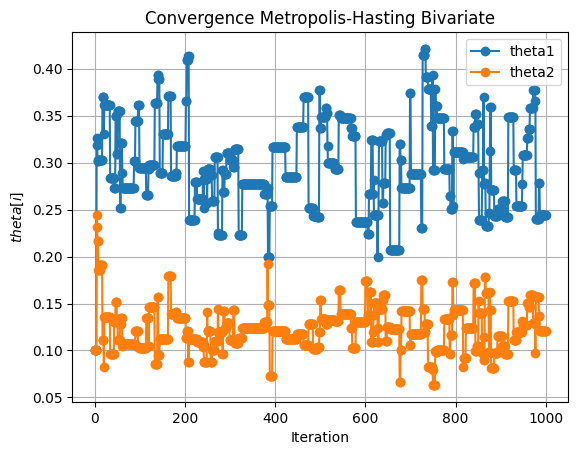

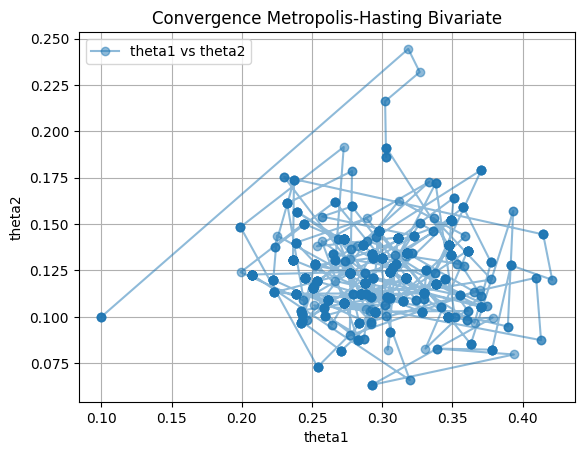

In [138]:
plt.plot(np.array(theta)[:, 0], '-o', label='theta1')
plt.plot(np.array(theta)[:, 1], '-o', label='theta2')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('$theta[i]$')
plt.title('Convergence Metropolis-Hasting Bivariate')
plt.grid()
plt.show()

plt.plot(np.array(theta)[:, 0], np.array(theta)[:, 1], '-o', label='theta1 vs theta2', alpha=0.5)
plt.legend()
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.title('Convergence Metropolis-Hasting Bivariate')
plt.grid()
plt.show()

## MCMC on Cars Dataset

This dataset contains speend and stopping sitancce of different vehicles. We wii assume simple linear regression to model distance as function of speed. Prior is taken as normal and likelihood is considered under observation that error will follow normal distribution with 0 mean and $\sigma^2$ variance. 

$ y:$ Distance
$ x:$ Speed

$$ y = ax + b + \epsilon $$
$$ \epsilon \sim \mathcal{N}(0, \sigma^2) $$ 
Parameters of inferene: $$ \theta = [a, b, \sigma] $$
Data: $$ X = [x_1, x_2, \dots, x_n], Y = [y_1, y_2, \dots, y_n] $$
Likelihood: $$ y_i - ax_i - b \sim \mathcal{N}(0, \sigma^2) $$
$$ \mathcal{L}(\theta|(X,Y)) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - ax_i - b)^2}{2\sigma^2}\right) $$

We will consider log likelihood to avoid numerical overflow. 
$$ \log \mathcal{L}(\theta|(X,Y)) = \sum_{i=1}^{n} \left[ -\frac{1}{2} \log(2\pi\sigma^2) - \frac{(y_i - ax_i - b)^2}{2\sigma^2} \right] $$

Prior: 
$$ f(\theta) = f_{\mathcal{N}(0, 1)}(a) * f_{\mathcal{N}(0, 0.5)}(b) * f_{\mathcal{gamma}(0.5, 1)}(\sigma^2) $$
We wiil consider log prior. 
$$ \log f(\theta) = \log f_{\mathcal{N}(0, 1)}(a) + \log f_{\mathcal{N}(0, 0.5)}(b) + \log f_{\mathcal{gamma}(0.5, 1)}(\sigma^2) $$ 
Proposal Distribution:
$$ \theta' \mid \theta \sim \text{Multivariate Normal, mean = $\theta$} $$ 
$$ \alpha = \exp \left( \left( \log \mathcal{L}(\theta'|(X,Y)) + \log f(\theta') \right) - \left( \log \mathcal{L}(\theta|(X,Y)) + \log f(\theta) \right) \right)

In [139]:
data = pd.read_csv('../cars.csv')

x = data['speed'].values
y = data['dist'].values

print(x.shape, y.shape)

(50,) (50,)


In [140]:
def likelihood(a, b, sigma):
    return stats.norm.logpdf(y, a*x+b, sigma).sum()

def prior(a, b, sigma):
    return stats.norm.logpdf(a, 0, 1) + stats.norm.logpdf(b, 0, 0.5) + stats.gamma.logpdf(sigma, 0.5, 1)


def metropolis_hasting_car(x, y, a_init, b_init, sigma_init, n_iter=5000):
    
    theta = [(a_init, b_init, sigma_init)]
    theta_current = (a_init, b_init, sigma_init)
    
    for i in range(n_iter):
        
        theta_prop = (np.random.normal(theta_current[0], 0.1), np.random.normal(theta_current[1], 0.1), np.random.normal(theta_current[2], 0.1))
        
        if theta_prop[2] < 0:
            continue
        
        q_prop = likelihood(theta_prop[0], theta_prop[1], theta_prop[2]) + prior(theta_prop[0], theta_prop[1], theta_prop[2])
        q_current = likelihood(theta_current[0], theta_current[1], theta_current[2]) + prior(theta_current[0], theta_current[1], theta_current[2])
        
        alpha = np.exp(q_prop - q_current)
        
        if np.random.uniform() < alpha:
            theta_current = theta_prop
        
        theta.append(theta_current)
    
    return theta

In [141]:
theta = metropolis_hasting_car(x, y, 0, 0, 12)
theta = np.array(theta)

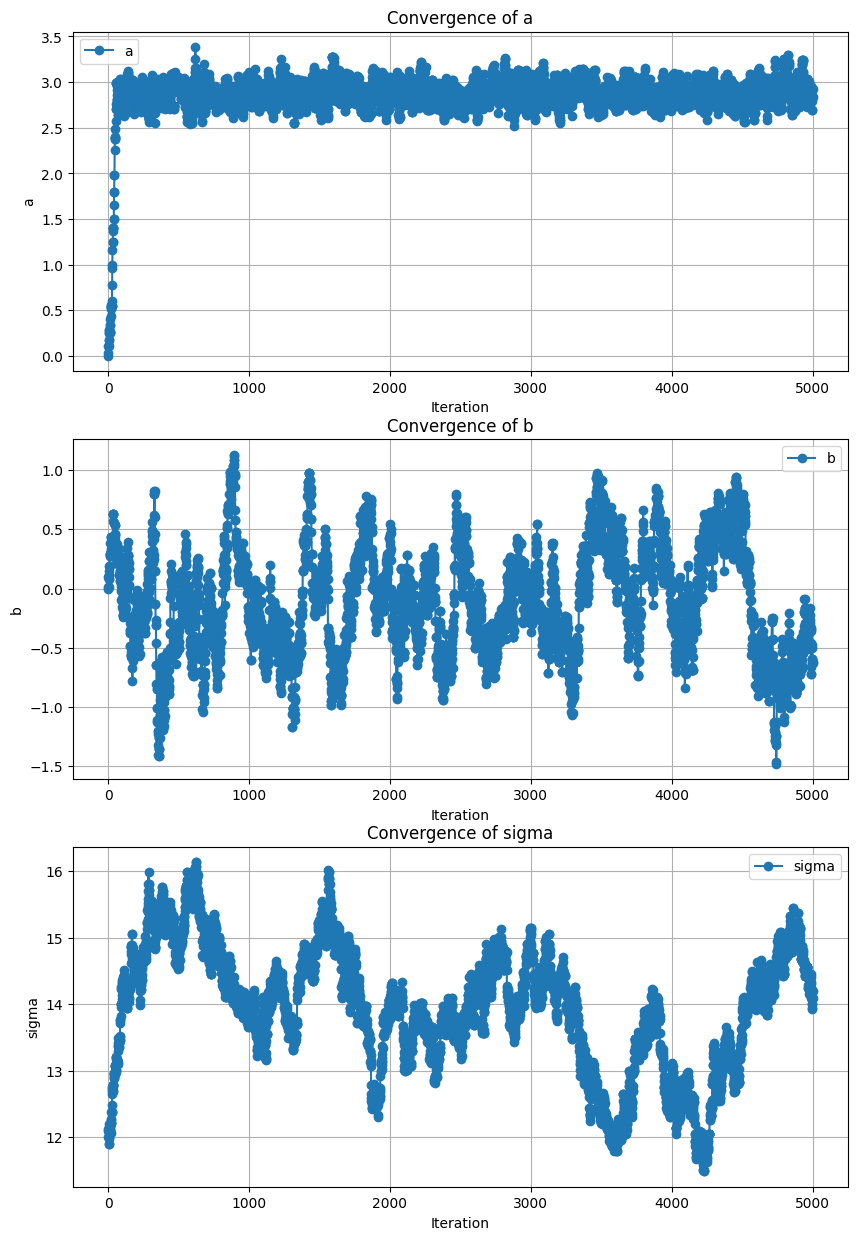

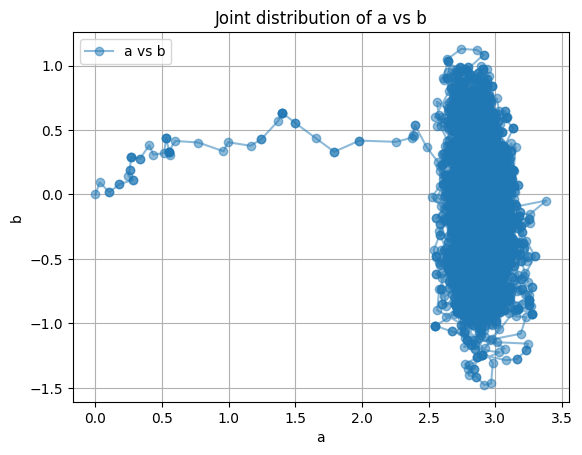

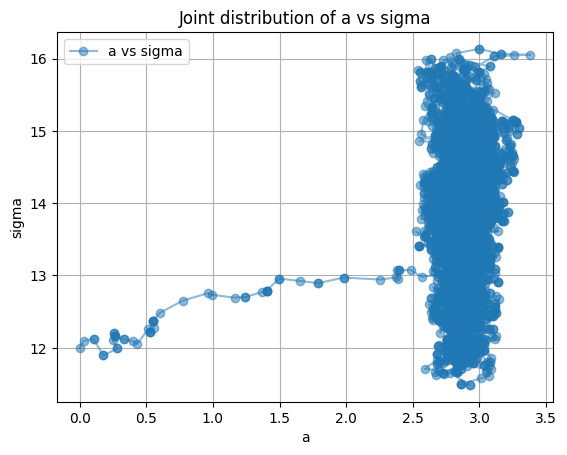

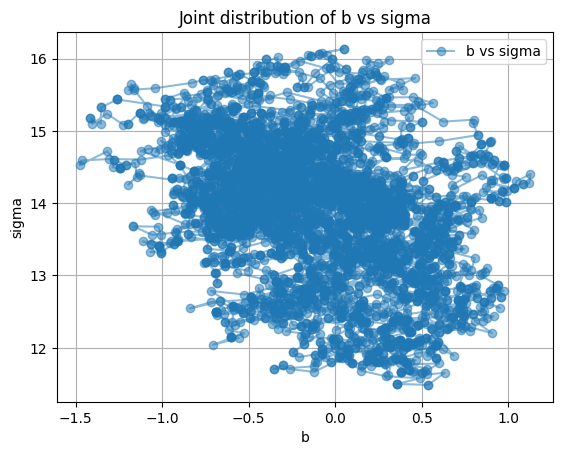

In [142]:
# plot convergence in subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].plot(theta[:, 0], '-o', label='a')
ax[0].grid()
ax[0].set_title('Convergence of a')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('a')
ax[0].legend()

ax[1].plot(theta[:, 1], '-o', label='b')
ax[1].grid()
ax[1].set_title('Convergence of b')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('b')
ax[1].legend()

ax[2].plot(theta[:, 2], '-o', label='sigma')
ax[2].grid()
ax[2].set_title('Convergence of sigma')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('sigma')
ax[2].legend()
plt.show()

# plot joint distribution
plt.plot(theta[:, 0], theta[:, 1], '-o', label='a vs b', alpha=0.5)
plt.grid()
plt.xlabel('a')
plt.ylabel('b')
plt.title('Joint distribution of a vs b')
plt.legend()
plt.show()

# plot joint distribution
plt.plot(theta[:, 0], theta[:, 2], '-o', label='a vs sigma', alpha=0.5)
plt.grid()
plt.xlabel('a')
plt.ylabel('sigma')
plt.title('Joint distribution of a vs sigma')
plt.legend()
plt.show()

# plot joint distribution
plt.plot(theta[:, 1], theta[:, 2], '-o', label='b vs sigma', alpha=0.5)
plt.grid()
plt.xlabel('b')
plt.ylabel('sigma')
plt.title('Joint distribution of b vs sigma')
plt.legend()
plt.show()

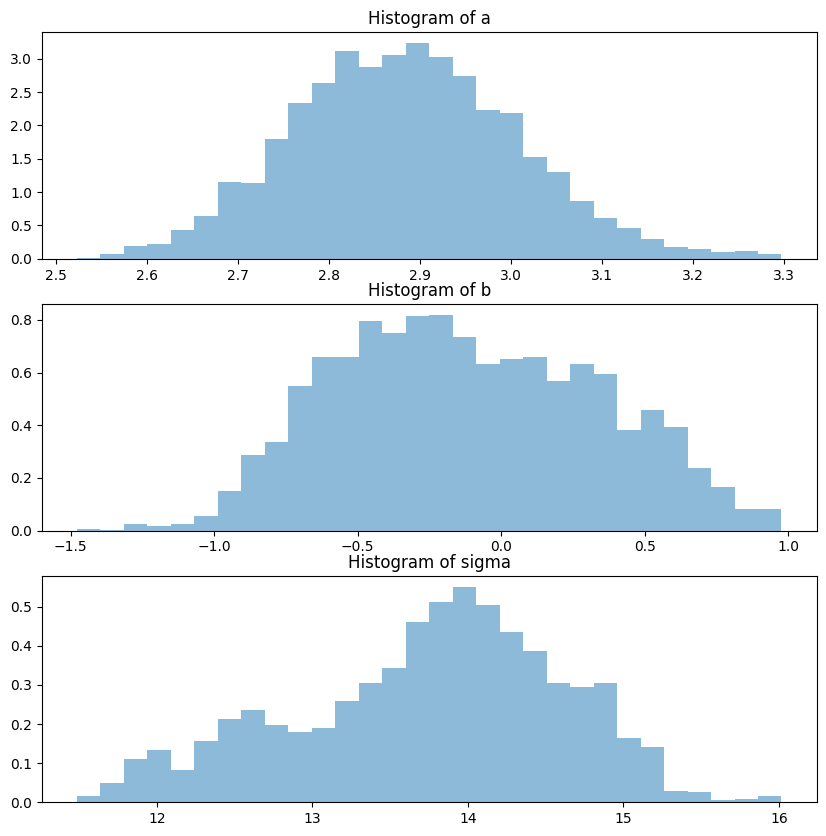

In [143]:
a_samples = theta[1001:, 0]
b_samples = theta[1001:, 1]
sigma_samples = theta[1001:, 2]

# plot marginal distribution in subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(a_samples, bins=30, density=True, alpha=0.5)
ax[0].set_title('Histogram of a')
ax[1].hist(b_samples, bins=30, density=True, alpha=0.5)
ax[1].set_title('Histogram of b')
ax[2].hist(sigma_samples, bins=30, density=True, alpha=0.5)
ax[2].set_title('Histogram of sigma')
plt.show()

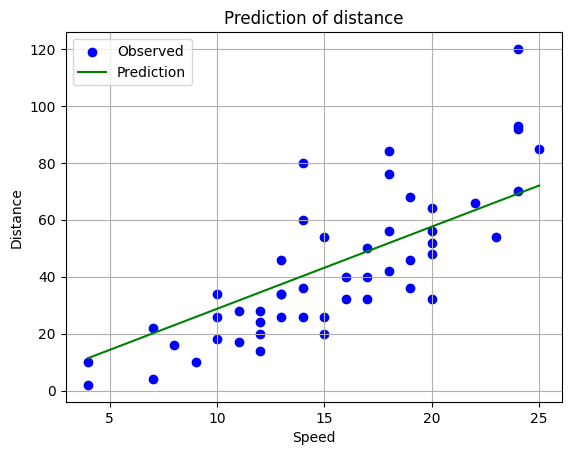

a_mean=2.88, b_mean=-0.12, sigma_sq_mean=13.75
a_std=0.12, b_std=0.45, sigma_sq_std=0.86
MSE=258.91


In [146]:
a_mean = a_samples.mean()
b_mean = b_samples.mean()
sigma_mean = sigma_samples.mean()

y_pred = a_mean * x + b_mean
plt.scatter(x, y, label='Observed', color='blue')
plt.plot(x, y_pred, label='Prediction', color='green')
plt.xlabel('Speed')
plt.ylabel('Distance')
plt.title('Prediction of distance')
plt.legend()
plt.grid()
plt.show()

print(f'a_mean={a_mean:.2f}, b_mean={b_mean:.2f}, sigma_sq_mean={sigma_mean:.2f}')
print(f'a_std={a_samples.std():.2f}, b_std={b_samples.std():.2f}, sigma_sq_std={sigma_samples.std():.2f}')

MSE = ((y - y_pred) ** 2).mean()
print(f'MSE={MSE:.2f}')